# Automatic Clusterization of Unstructured Property Listings for Psychological Assessments

_Fabián Villena Rodríguez_

## Problem
Property listing task is a psicological assessment where patients have to fill in properties that they think relates to a given concept without naming the concept. These properties are in the form of free text, so the patient can write down without restriction. To further analyse the results, a human must review all properties and then classsify each property into major categories, this process is highly inconsistent and leads to a difficult analysis and possible false conclusions.

## Solution
Automatically cluster the properties without human intervention to systematically group semantically similar concepts into major categories in a consistent manner.

## Hypothesis
A machine learning approach to cluster free-text properties can mimic the human classification classes distribution of these propertier, obtaining similar result in a shorter time.

## Method
To perform the clusterization of the properties, a machine learning approach was applied. The development of the solution was made in Python programming language, using word embeddings to map words into a vector representation of its semantic, to further apply clusterization algorithms to group the properties. The process is explained in the nexs cells.

In [1]:
# %matplotlib inline # plotting the graphs non-interactively
import gensim # module for computing word embeddings
import pandas as pd # more robust data stractures (dataframes)
import numpy as np # linear algebra module
import sklearn.feature_extraction # package to perform tf-idf vertorization
import sklearn.cluster # clusterization algorithms
import sklearn.preprocessing # label encoder 
import sklearn.manifold # dimensionality reduction
import matplotlib.pyplot as plt # visualization
import itertools
pd.set_option('display.max_rows', 100) # make panda show more rows

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format( # loading word embeddings
    r'../models/SBW-vectors-300-min5.bin', # using the spanish billion words embeddings
    binary=True # the model is in binary format
)

In [8]:
data = pd.read_excel( # loading the data
    r'../data/raw/Datos Codificados Estudio v2.xlsx'
)

In [9]:
data['Palabra (concepto)'] = data['Palabra (concepto)'].apply(str.lower) # conver to lower case a column
data['Descripción'] = data['Descripción'].apply(str.lower) 
data['Codificación'] = data['Codificación'].apply(str.lower) 

In [10]:
data.sample(5) # sample of 5 data points

,Correlativo,Sujeto Número,Palabra (concepto),Descripción,Orden de Aparición de la Descripción,IMPL o EXPL,Codificación,Orden de Aparición de la Codificación,Frecuencia de codifiación por concepto,Criterio asig. Tipo (1 ó 2)
4682,4686.0,93,pensamiento,proceso cognitivo interno,1,NaN,cognitivo,1.0,3.0,1
1634,1636.0,34,desesperación,creer que ya no existen mas posibilidades,6,NaN,sin salida,6.0,3.0,1
1623,1625.0,33,razón,se desarrolla por el pensamiento,4,NaN,pensamiento,4.0,17.0,1
4163,4167.0,79,obsesión,asociado al trastorno compulsivo,2,NaN,trastorno,2.0,7.0,1
1760,1763.0,36,éxito,prosperar,1,NaN,properidad,1.0,1.0,1


In [11]:
data['Descripción'].count() # number of data points

4938

In [12]:
data['Codificación'].value_counts()[data['Codificación'].value_counts() != 1] # number of data points without code

bien               80
idea               55
habilidades        52
pensamiento        44
mal                43
positivo           42
gratitud           41
sentimiento        38
verdad             37
riesgo             36
ayuda              36
mente              35
angustia           34
capacidad          34
alegría            33
confianza          31
no mentir          30
deber              30
elección           30
peligro            29
responsabilidad    28
advertencia        28
protección         28
empatía            28
felicidad          28
daño               28
logro              27
fe                 27
organización       25
hacer              25
miedo              24
acción             24
emoción            24
tranquilidad       24
humano             23
inseguridad        22
nerviosismo        21
correcto           21
lógica             20
negativo           20
amenaza            20
razonamiento       20
opción             19
explicación        19
transparencia      19
necesario 

In [13]:
data['Codificación'].value_counts().count() # number of properties

1294

In [14]:
tfidfvectorizer = sklearn.feature_extraction.text.TfidfVectorizer() # instance of the tf-idf vectorizer
tfidfvectorizer.fit(data['Descripción']) # fitting the vectorizer and transforming the properties

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [15]:
idf = {key:val for key,val in zip(tfidfvectorizer.get_feature_names(),tfidfvectorizer.idf_)}

In [16]:
def to_vector(texto,model):
    """ Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence"""
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(300) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if (word in model) & (word in idf): # checks if the word is both in the word embedding and the tf-idf model
            vec += model[word]*idf[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) # divides the vector by their normal

In [17]:
texto = 'pone en riesgo la integridad' # test sentence
to_vector(texto,model)[:30] # example of the first 30 components of the sentence vector

array([-0.02308965, -0.01245489,  0.06393057, -0.00593836,  0.04156472,
        0.06236711, -0.08090533, -0.07934865,  0.08091643, -0.00820033,
        0.11165872, -0.05971171, -0.01205922, -0.0540102 ,  0.01548854,
       -0.02285566, -0.00997002,  0.01797955,  0.03328569,  0.11699641,
        0.03819035, -0.09431122,  0.02962123,  0.0321849 ,  0.05470428,
       -0.02253823, -0.00125454,  0.04004915, -0.01155927,  0.13005375])

In [18]:
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of rows is equal to the number of data points
        len(model['hola']) # the number of columns is equal to the number of components of the word embedding
    )
)

In [19]:
for i,description in enumerate(data['Descripción']):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

/home/fvillena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [20]:
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)

In [21]:
data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:300]).any(axis=1)]

In [22]:
tisni = sklearn.manifold.TSNE(verbose=True)

In [23]:
tisni.fit(data_matrix_without_nan[:,:300])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4906 samples in 0.045s...
[t-SNE] Computed neighbors for 4906 samples in 12.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4906
[t-SNE] Computed conditional probabilities for sample 2000 / 4906
[t-SNE] Computed conditional probabilities for sample 3000 / 4906
[t-SNE] Computed conditional probabilities for sample 4000 / 4906
[t-SNE] Computed conditional probabilities for sample 4906 / 4906
[t-SNE] Mean sigma: 0.237281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.800171
[t-SNE] KL divergence after 1000 iterations: 2.117760


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=True)

In [23]:
# Sum_of_squared_distances = []
# K = range(1,4000,100)
# for k in K:
#     km = sklearn.cluster.KMeans(n_clusters=k,n_jobs=-1)
#     km = km.fit(data_matrix_without_nan[:,:300])
#     Sum_of_squared_distances.append(km.inertia_)

In [24]:
# plt.plot(K, Sum_of_squared_distances)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method For Optimal Number of Clusters')
# plt.show()

In [24]:
kemean = sklearn.cluster.KMeans(n_clusters = 500, n_jobs=-1)
kemean.fit(data_matrix_without_nan[:,:300])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=500, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
kemean_counts = np.unique(kemean.labels_, return_counts=True)

In [26]:
kemean_counts = np.concatenate([
    np.reshape(kemean_counts[0], (-1, 1)),
    np.reshape(kemean_counts[1], (-1, 1))
], axis=1)

In [27]:
kemean_counts.sort(axis=0)

In [28]:
hier = sklearn.cluster.AgglomerativeClustering(n_clusters = 500)
hier.fit(data_matrix_without_nan[:,:300])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=500,
                        pooling_func='deprecated')

In [29]:
hier_counts = np.unique(hier.labels_, return_counts=True)

In [30]:
hier_counts = np.concatenate([
    np.reshape(hier_counts[0], (-1, 1)),
    np.reshape(hier_counts[1], (-1, 1))
], axis=1)

In [31]:
hier_counts.sort(axis=0)

In [32]:
debescan = sklearn.cluster.DBSCAN(eps=0.1, min_samples=5)
debescan.fit(data_matrix_without_nan[:,:300])

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [33]:
debescan_counts = np.unique(debescan.labels_[debescan.labels_ != -1], return_counts=True)

In [34]:
debescan_counts = np.concatenate([
    np.reshape(debescan_counts[0], (-1, 1)),
    np.reshape(debescan_counts[1], (-1, 1))
], axis=1)

In [35]:
debescan_counts.sort(axis=0)

In [36]:
optic = sklearn.cluster.OPTICS(
    metric='minkowski',
    n_jobs=-1
)
optic.fit(data_matrix_without_nan[:,:300])

/home/fvillena/anaconda3/lib/python3.7/site-packages/sklearn/cluster/optics_.py:795: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=5, n_jobs=-1, p=2,
       predecessor_correction=True, xi=0.05)

In [37]:
optic_counts = np.unique(optic.labels_[optic.labels_ != -1], return_counts=True)

In [38]:
optic_counts = np.concatenate([
    np.reshape(optic_counts[0], (-1, 1)),
    np.reshape(optic_counts[1], (-1, 1))
], axis=1)

In [39]:
optic_counts.sort(axis=0)

## Results
The clusterization by clusterization method is shown in the next figure.

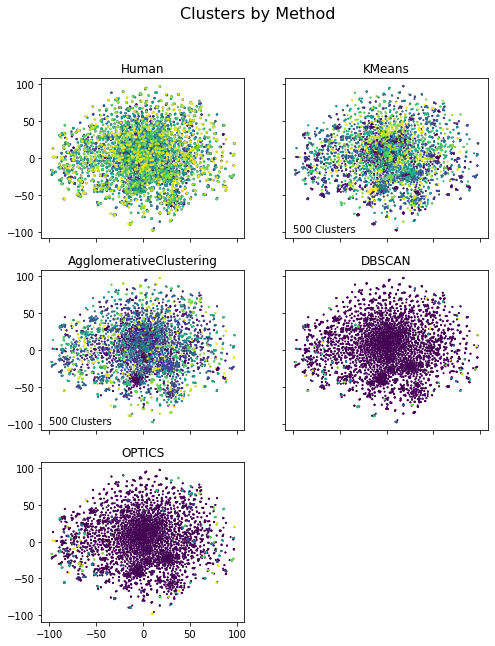

In [40]:
fig, axs = plt.subplots(
    3, 2, 
    sharex=True, 
    sharey=True
)
fig.set_size_inches(8, 10)
fig.suptitle('Clusters by Method', fontsize=16)
axs[0, 0].set_title('Human')
axs[0,0].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = data_matrix_without_nan[:,300],
    s = 2
           )
axs[0, 1].set_title('KMeans')
axs[0, 1].text(-100, -100, '500 Clusters')
axs[0,1].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = kemean.labels_,
    s = 1
           )
axs[1, 0].set_title('AgglomerativeClustering')
axs[1, 0].text(-100, -100, '500 Clusters')
axs[1,0].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = hier.labels_,
    s = 1
           )
axs[1, 1].set_title('DBSCAN')
axs[1,1].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = debescan.labels_,
    s = 1
           )
axs[2, 0].set_title('OPTICS')
axs[2,0].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = optic.labels_,
    s = 1
           )
fig.delaxes(axs[2,1])
plt.show()

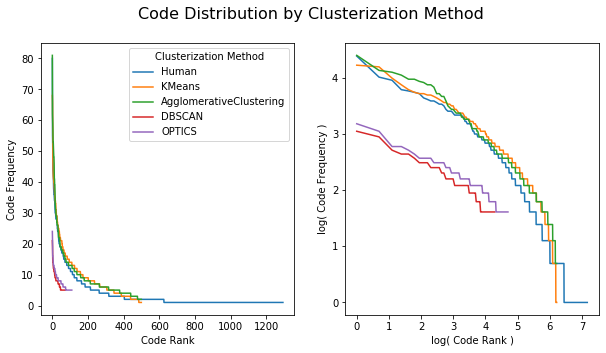

In [41]:
fig, axs = plt.subplots(
    1, 2, 
    sharex=False, 
    sharey=False
)
fig.suptitle('Code Distribution by Clusterization Method', fontsize=16)
fig.set_size_inches(10, 5)
axs[0].plot(
    data['Codificación'].value_counts().values,
    label='Human'
)
axs[1].plot(
    np.log(list(range(1,len(data['Codificación'].value_counts().values)+1))),
    np.log(data['Codificación'].value_counts().values),
    label='Human'
)
axs[0].plot(
    kemean_counts[::-1][:,1],
    label='KMeans'
)
axs[1].plot(
    np.log(list(range(1,len(kemean_counts[::-1][:,1])+1))),
    np.log(kemean_counts[::-1][:,1]),
    label='KMeans'
)
axs[0].plot(
    hier_counts[::-1][:,1],
    label='AgglomerativeClustering'
)
axs[1].plot(
    np.log(list(range(1,len(hier_counts[::-1][:,1])+1))),
    np.log(hier_counts[::-1][:,1]),
    label='AgglomerativeClustering'
)
axs[0].plot(
    debescan_counts[::-1][:,1],
    label='DBSCAN'
)
axs[1].plot(
    np.log(list(range(1,len(debescan_counts[::-1][:,1])+1))),
    np.log(debescan_counts[::-1][:,1]),
    label='DBSCAN'
)
axs[0].plot(
    optic_counts[::-1][:,1],
    label='OPTICS'
)
axs[1].plot(
    np.log(list(range(1,len(optic_counts[::-1][:,1])+1))),
    np.log(optic_counts[::-1][:,1]),
    label='OPTICS'
)
axs[0].set_ylabel('Code Frequency')
axs[0].set_xlabel('Code Rank')
axs[1].set_ylabel('log( Code Frequency )')
axs[1].set_xlabel('log( Code Rank )')
axs[0].legend(title="Clusterization Method")

In [42]:
all_codes = np.concatenate([data_matrix_without_nan[:,300:],
                np.reshape(kemean.labels_, (-1, 1)),
                np.reshape(hier.labels_, (-1, 1)),
                np.reshape(debescan.labels_, (-1, 1)),
                np.reshape(optic.labels_, (-1, 1)),
               ],axis=1)

In [43]:
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

In [44]:
data.columns

Index(['Correlativo', 'Sujeto Número', 'Palabra (concepto)', 'Descripción',
       'Orden de Aparición de la Descripción', 'IMPL o EXPL', 'Codificación',
       'Orden de Aparición de la Codificación',
       'Frecuencia de codifiación por concepto',
       'Criterio asig. Tipo (1 ó 2)'],
      dtype='object')

In [46]:
codes_comparison = pd.DataFrame(
    all_codes,columns=['Correlativo', 'Sujeto Número', 'Palabra (concepto)', 'Descripción',
       'Orden de Aparición de la Descripción', 'IMPL o EXPL', 'Human',
       'Orden de Aparición de la Codificación',
       'Frecuencia de codifiación por concepto',
       'Criterio asig. Tipo (1 ó 2)','KMeans','AgglomerativeClustering','DBSCAN','OPTICS']
)

KMeans_dict = codes_comparison[['Human','KMeans']].groupby(by='KMeans')['Human'].apply(list).to_dict()
KMeans_categories = {}
for key, val in KMeans_dict.items():
    KMeans_categories[key] = most_frequent(val)
    
AgglomerativeClustering_dict = codes_comparison[['Human','AgglomerativeClustering']].groupby(by='AgglomerativeClustering')['Human'].apply(list).to_dict()
AgglomerativeClustering_categories = {}
for key, val in AgglomerativeClustering_dict.items():
    AgglomerativeClustering_categories[key] = most_frequent(val)

DBSCAN_dict = codes_comparison[['Human','DBSCAN']].groupby(by='DBSCAN')['Human'].apply(list).to_dict()
DBSCAN_categories = {}
for key, val in DBSCAN_dict.items():
    if key == -1:
        DBSCAN_categories[key] = 'outlier'
    else:
        DBSCAN_categories[key] = most_frequent(val)

OPTICS_dict = codes_comparison[['Human','OPTICS']].groupby(by='OPTICS')['Human'].apply(list).to_dict()
OPTICS_categories = {}
for key, val in OPTICS_dict.items():
    if key == -1:
        OPTICS_categories[key] = 'outlier'
    else:
        OPTICS_categories[key] = most_frequent(val)

codes_comparison['KMeans_code'] = codes_comparison['KMeans']
codes_comparison['AgglomerativeClustering_code'] = codes_comparison['AgglomerativeClustering']
codes_comparison['DBSCAN_code'] = codes_comparison['DBSCAN']
codes_comparison['OPTICS_code'] = codes_comparison['OPTICS']

codes_comparison['KMeans'] = codes_comparison['KMeans'].map(KMeans_categories)
codes_comparison['AgglomerativeClustering'] = codes_comparison['AgglomerativeClustering'].map(AgglomerativeClustering_categories)
codes_comparison['DBSCAN'] = codes_comparison['DBSCAN'].map(DBSCAN_categories)
codes_comparison['OPTICS'] = codes_comparison['OPTICS'].map(OPTICS_categories)

In [47]:
codes_distribution = codes_comparison.Human.value_counts().reset_index()
codes_distribution.columns = ['Human','frequency']

Example of the clusterization of the properties of the word _honestidad_ by clusterization method. The label _-1_ represents the data points which have no cluster in the density based methods.

In [48]:
codes_comparison.sort_values(
    by=['KMeans'], ascending=False
)[
    codes_comparison['Palabra (concepto)'] == 'honestidad'
][
    ['Descripción','Human', 'KMeans', 'AgglomerativeClustering', 'DBSCAN', 'OPTICS']
]

/home/fvillena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Descripción,Human,KMeans,AgglomerativeClustering,DBSCAN,OPTICS
1781,virtud,virtud,virtud,virtud,outlier,outlier
3924,virtud,virtud,virtud,virtud,outlier,outlier
2725,virtud,virtud,virtud,virtud,outlier,outlier
4232,es una virtud,virtud,virtud,virtud,outlier,outlier
465,se asocia al color blanco,blanco,verde,verde,outlier,outlier
4354,verdad,verdad,verdad,verdad,verdad,verdad
2726,consiste en decir la verdad,verdad,verdad,futuro,outlier,outlier
2729,principio moral y religioso muy extendido,moral,verdad,empatía,outlier,outlier
2289,cuando alguien dice la verdad,verdad,verdad,perdón,outlier,outlier
2563,expresa la verdad,verdad,verdad,afirmación,outlier,outlier


In [49]:
codes_comparison.sort_values(
    by=['KMeans'], ascending=False
)[
    codes_comparison.Human == 'logro'
][
    ['Descripción','Human', 'KMeans', 'AgglomerativeClustering', 'DBSCAN', 'OPTICS']
]

/home/fvillena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Descripción,Human,KMeans,AgglomerativeClustering,DBSCAN,OPTICS
1631,recibir algo despues de un logro,logro,personal,regalo,outlier,outlier
1214,lograr un objetivo,logro,objetivos,objetividad,outlier,objetivos
1751,lograr objetivo,logro,objetivos,objetividad,outlier,objetivos
4512,lograr un objetivo,logro,objetivos,objetividad,outlier,objetivos
3935,todos podemos lograrlo,logro,necesario,aprovechar,outlier,outlier
4900,lograr objetivos,logro,meta,meta,outlier,outlier
4847,lograr las metas,logro,meta,meta,outlier,outlier
4610,lograr cumplir objetivos,logro,meta,meta,outlier,outlier
4076,lograr las metas propuestas,logro,meta,meta,outlier,outlier
4608,lograr una meta pensada,logro,meta,meta,outlier,meta


In [51]:
codes_comparison.to_csv('../data/processed/processed_dataset.csv', index=False)

## Discussion

Using as a gold standard the human codification, the most similar frequency distribution of codes are the KMeans and Hierarchical Clustering methods using 500 clusters. This pseudo-logarithmic distribution can be associated with Zipf law which states that in some physical and social phenomena the frequency of an event is inversely proportional to their rank. The distribution described here could be associated with the distribution of words in the natural language itself and not necessarily associated with this specific property listing task.

Using the density based methods for clusterization a non-logarithmic distribution was found. Making a cuantitative analysis of the clusterization made by this methods, a more granular grouping of terms is found. This more granular codification could extract more topic specific information because it is not grouping a large number of properties on a single big category.

## Conclusion
Using unsupervised machine learning methods, the codification of property listing tasks can be made whithout human intervention achieving a human-coded distribution of codes.